## This notebook is used to explore how different features impacts the RF algorithm on predicting Prot. Data from https://arxiv.org/abs/1402.5694

In [360]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   'text.usetex': False,
   }
plt.rcParams.update(params)

Read in data

In [185]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.utils as au
from astropy.io import fits

# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
print('McQuillian',np.shape(McQS))

# gaia data from https://gaia-kepler.fun/
with fits.open('kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

# merge two tables with same KID
df = pd.merge(McQS, gaia, left_on="KID", right_on="kepid", how="inner")
#print(df)

# drop duplicates
df.drop_duplicates(subset ="KID", keep = False, inplace = True) 
print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]-np.shape(df)[0]))

McQuillian (34030, 11)
Cross-matched (32984, 145)
Missing 1046 stars


# [1] Get Velocity

Code from Adrian Price-Whelan to calculate $v_{tan}=\sqrt{v_{ra}^2+v_{dec}^2}$ and $v_b$

In [229]:
import astropy.coordinates as coord
d = coord.Distance(parallax=np.array(df.parallax) * u.mas,allow_negative=True)
vra = (np.array(df.pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
vdec = (np.array(df.pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
# v_b as a proxy for v_z:
c = coord.SkyCoord(ra=np.array(df.ra)*u.deg, dec=np.array(df.dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(df.pmra)*u.mas/u.yr,
                  pm_dec=np.array(df.pmdec)*u.mas/u.yr)
gal = c.galactic
v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
# print(vb)

# add v_b and v_tan into dataframe
df['v_b']=v_b
df['v_tan']=v_t
df=df.dropna(subset=['v_b','v_tan'])
print(df)

/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:90: RuntimeWarning: invalid value encountered in less
  d[d < 0] = np.nan
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/lucy/anaconda3/lib/pytho

            KID  Teff  logg_x    Mass    Prot  Prot_err      Rper    LPH  \
0        892376  3813    4.47  0.4699   1.532     0.007   7306.69  0.823   
1       1026146  4261    4.57  0.6472  14.891     0.120  11742.56  1.405   
2       1026474  4122    4.56  0.5914   1.569     0.006  30471.80  1.204   
3       1162635  3760    4.77  0.4497  15.678     0.019  10207.47  0.978   
4       1164102  4045    4.62  0.5606  31.496     0.474   5139.74  0.568   
...         ...   ...     ...     ...     ...       ...       ...    ...   
34885  12934451  5556    4.46  0.9798  17.244     0.567   2147.85  0.435   
34886  12934465  4714    4.88  0.7591  34.910     1.692   4572.33  0.433   
34887  12934525  5278    4.72  0.9062  25.101     0.240   5150.14  0.573   
34888  12934557  5341    4.58  0.9227  31.226     0.729   1889.88  0.401   
34889  12984138  4960    4.57  0.8239  12.059     0.038  11734.90  1.194   

            w  DC  ... nconfp  nkoi ntce    jmag    hmag    kmag  planet?  \
0      0.4

# [1] Random Forest

In [289]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize
# can ignore multiple features (already excluding Prot, M14, C16)
def my_randF_mask(df,traind,ignf_2=[]):
    # inputs
    # other features: R35, R1s? 
    # df: the data
    # traind: what fraction of data use to train
    # ignf_2: what features to ignor
    
    # outputs:
    # flib: lib for features indexed
    # regr: trained model
    # importance: importance of features
    # actrualF: actrual feature used
    # predictp: predicted periods
    
    # ignored features
    ignf=['Prot','Prot_err','M14','C16','source_id','solution_id','gaia_ref_epoch','random_index','ntce','DC','matched_observations','kepid']+ignf_2
    print('ignored features',ignf)
    # number the features with dictionary
    fl=len(df.columns) # how many features
    keys=range(fl)
    flib=dict(zip(keys, df.columns))

    featl_o=len(df.Prot) # old feature length before dropping

    actrualF=[] # actrual feature used
    # fill in feature array
    lenX=0
    for i in df.columns:
        #print(i)
        feature=df[i]
        # if input not string, not Prot
        if (type(feature[0]) is not str) and (i not in ignf) and sum(np.isnan(feature))<0.05*featl_o:
            #if (np.isnan(feature).any()):
            #    print(i)
            #    print(feature[np.isnan(feature)])
            lenX=lenX+1
            actrualF.append(i)
            
    X=df[actrualF]
    X=X.replace([np.inf, -np.inf], np.nan)
    X=X.dropna()
    featl=np.shape(X)[0]
    if (featl_o-featl)!=0:
        print('Missing '+ str(featl_o-featl)+' stars to train!')
    
    Ntrain = int(traind*featl)

    # output
    y=df.Prot[X.index].values
    y_err=df.Prot_err[X.index].values
    X=X.values
    
    # Choose stars at random and split.
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
    train_inds = shuffle_inds[:Ntrain]
    test_inds = shuffle_inds[Ntrain:]
    y_train, y_train_err,X_train = y[train_inds], y_err[train_inds],X[train_inds, :]
    y_test, y_test_err,X_test = y[test_inds], y_err[test_inds],X[test_inds, :]
    

    # run random forest
    regr = RandomForestRegressor(random_state=0,n_estimators=100)
    regr.fit(X_train, y_train)  

    # get the importance of each feature
    importance=regr.feature_importances_
    
    # make prediction
    predictp=np.zeros([len(range(int(traind*featl),featl)),1]) # predicted period
    difc=0
    for i in range(len(y_test)):
        predictp[difc]=regr.predict([X_test[i,:]])
        difc=difc+1
    
    return flib,regr,importance,actrualF,predictp,X,y_test,y_test_err

In [385]:
# calculates chisq
def calcChi(Prot,Prot_pre,Prot_err):
    # Prot: rotation periods
    # Prot_pre: predicted rotation periods
    # Prot_err: rotation period errors
    validv=0
    for i in range(len(Prot)):
        if Prot_err[i]==0:
            Prot[i]=0
            Prot_pre[i]=0
            Prot_err[i]=1
            validv=validv+1
    avstedv=sum([(Prot[i]-Prot_pre[i])**2./Prot_err[i] for i in range(len(Prot_err))])/(len(Prot_pre)-validv)
    return avstedv
    
# for plotting results for importance and predict vs true
def plot_result(actrualF,importance,prediction,y_test,y_test_err,topn=20):
    # inputs:
    # actrualF: feature used in training (output from my_randF_mask)
    # importance/prediction: output from my_randF function
    # topn: how many features to plot (default=20)
    # X: features, if X is inputed then plot feature vs Prot
    # y_test: tested values
    # y_test_err: tested values errors
    
    # output: 
    # my_xticks: importance of features in decending order
    
    # zip the importance with its feature name
    list1 = list(zip(actrualF,importance))
    # sort the zipped list
    decend=sorted(list1, key=lambda x:x[1],reverse=True)
    #print(decend)

    # how many features to plot 
    x=range(topn)

    #print('ra_dec_corr : Correlation between right ascension and declination. Correlation coefficient ρ(α,δ)between right ascension and declination, a dimensionless quantity in the range [-1,+1]')
    #print('Rper: the average amplitude of variability within one period')
    #print('LPH: the height of the selected peak with respect to the mean of the troughs on either side')
    ####################  get most important features ############################################################
    # get index and value for y
    y_val=[decend[i][1] for i in range(topn)]
    my_xticks=[decend[i][0] for i in range(topn)]

    plt.figure(figsize=(20,5))
    plt.title('Most important features',fontsize=25)
    plt.xticks(x, my_xticks)
    plt.plot(x, y_val,'k-')
    plt.xlim([min(x),max(x)])
    plt.xticks(rotation=90)
    plt.ylabel('importance')
    ####################  get most important features ############################################################

    # prediction vs true
    plt.figure(figsize=(10,8))
    plt.plot(sorted(prediction),sorted(prediction),'k-',label='y=x')
    plt.plot(sorted(prediction),sorted(1.1*prediction),'b--',label='10% Error')
    plt.plot(sorted(prediction),sorted(0.9*prediction),'b--')
    plt.errorbar(y_test,prediction,xerr=y_test_err,fmt='r.',Markersize=3,alpha=0.2)
    plt.ylabel('Predicted Period')
    plt.xlabel('True Period')
    plt.ylim([0,max(prediction)])
    plt.xlim([0,max(prediction)])
    plt.legend()
    #plt.savefig('RF.png')
    
    avstedv=calcChi(y_test,prediction,y_test_err)
    print('average chisq is: ',avstedv)
    return(my_xticks)

# plot different features vs Prot
def plot_corr(df,my_xticks,logplotarg=[],logarg=[]):
    # df: dataframe
    # my_xticks: features to plot against Prot
    # logplotarg: arguments to plot in loglog space
    # logarg: which log to plot
    
    # add in Prot
    Prot=df.Prot
    df=df[my_xticks].dropna()
    Prot=Prot[df.index]
    topn=len(my_xticks)
    # get subplot config
    com_mul=[] 
    # get all multiplier
    for i in range(1,topn):
        if float(topn)/float(i)-int(float(topn)/float(i))==0:
            com_mul.append(i)
        
    # total rows and columns
    col=int(np.median(com_mul))
    row=int(topn/col)
        
    # plot feature vs Prot
    plt.figure(figsize=(int(topn*2.5),int(topn*2.5)))
    for i in range(topn):
        plt.subplot(row,col,i+1)
        featurep=df[my_xticks[i]]
        if my_xticks[i] in logplotarg:
            if logarg=='loglog':
                plt.loglog(Prot,featurep,'k.',markersize=1)
            elif logarg=='logx':
                plt.semilogx(Prot,featurep,'k.',markersize=1)
            elif logarg=='logy':
                plt.semilogy(Prot,featurep,'k.',markersize=1)
            else:
                raise SyntaxError("Log scale input not recognized!")
        else:
            plt.plot(Prot,featurep,'k.',markersize=1)
        plt.title(my_xticks[i],fontsize=25)
        stddata=np.std(featurep)
        #print([np.median(featurep)-3*stddata,np.median(featurep)+3*stddata])
        plt.ylim([np.median(featurep)-3*stddata,np.median(featurep)+3*stddata])
        plt.xlabel('Prot')
        plt.ylabel(my_xticks[i])

    

# [3] For results including w

In [290]:
traind=0.7
flib,regr,importance,actrualF,predict,X,y_test,y_test_err=my_randF_mask(df,traind)
# get a score for cross-validation
#scores = cross_val_score(regr, X[int(traind*featl)+1:featl,:], np.array(df.Prot)[int(traind*featl)+1:featl], cv=10, scoring='neg_mean_absolute_error')

ignored features ['Prot', 'Prot_err', 'M14', 'C16', 'source_id', 'solution_id', 'gaia_ref_epoch', 'random_index', 'ra_error', 'ntce', 'DC', 'matched_observations', 'kepid']
Missing 1492 stars to train!


average chisq is:  [1115.04109211]


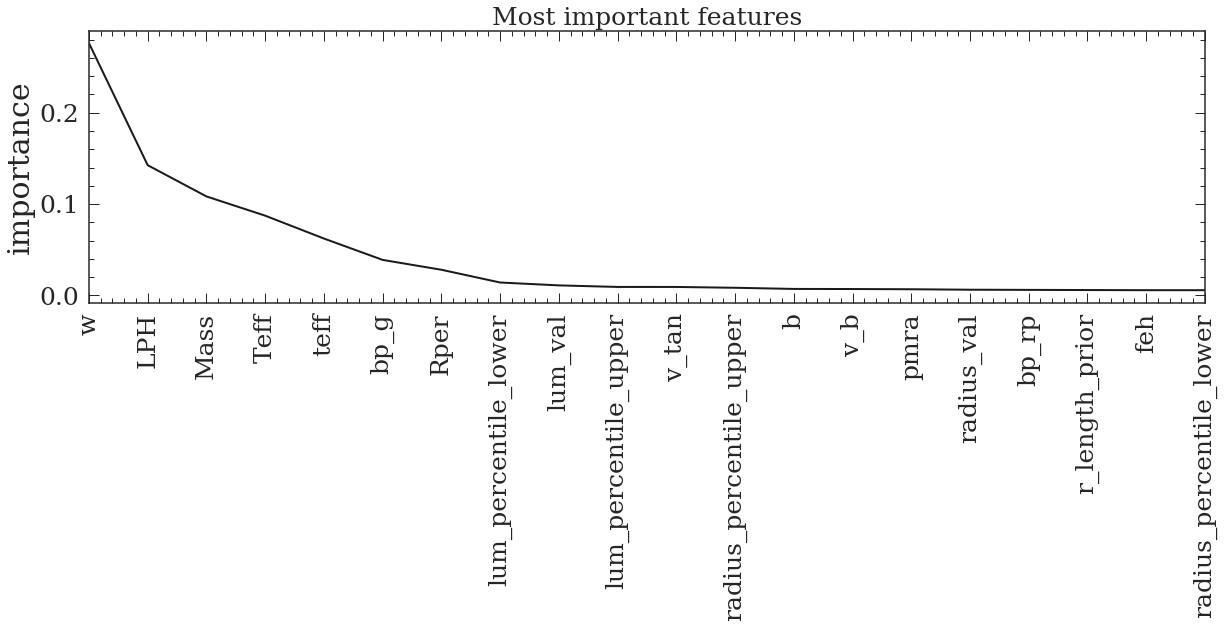

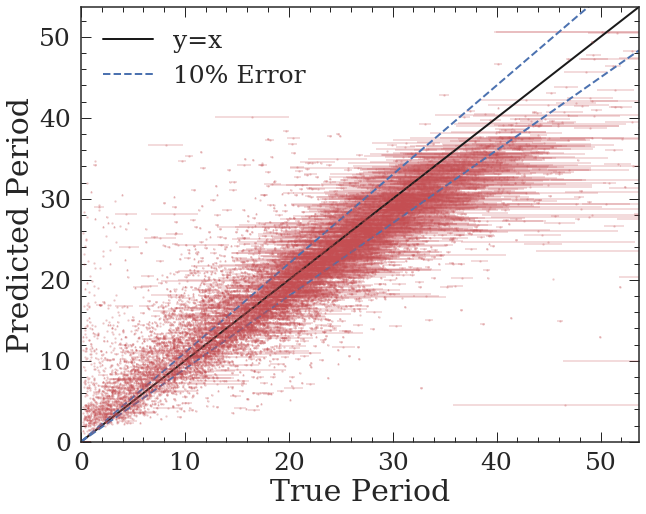

In [310]:
#print(actrualF)
x_ticks=plot_result(actrualF,importance,predict,y_test,y_test_err)  

['w', 'LPH', 'Mass', 'Teff', 'teff', 'bp_g', 'Rper', 'lum_percentile_lower', 'lum_val', 'lum_percentile_upper', 'v_tan', 'radius_percentile_upper', 'b', 'v_b', 'pmra', 'radius_val', 'bp_rp', 'r_length_prior', 'feh', 'radius_percentile_lower']


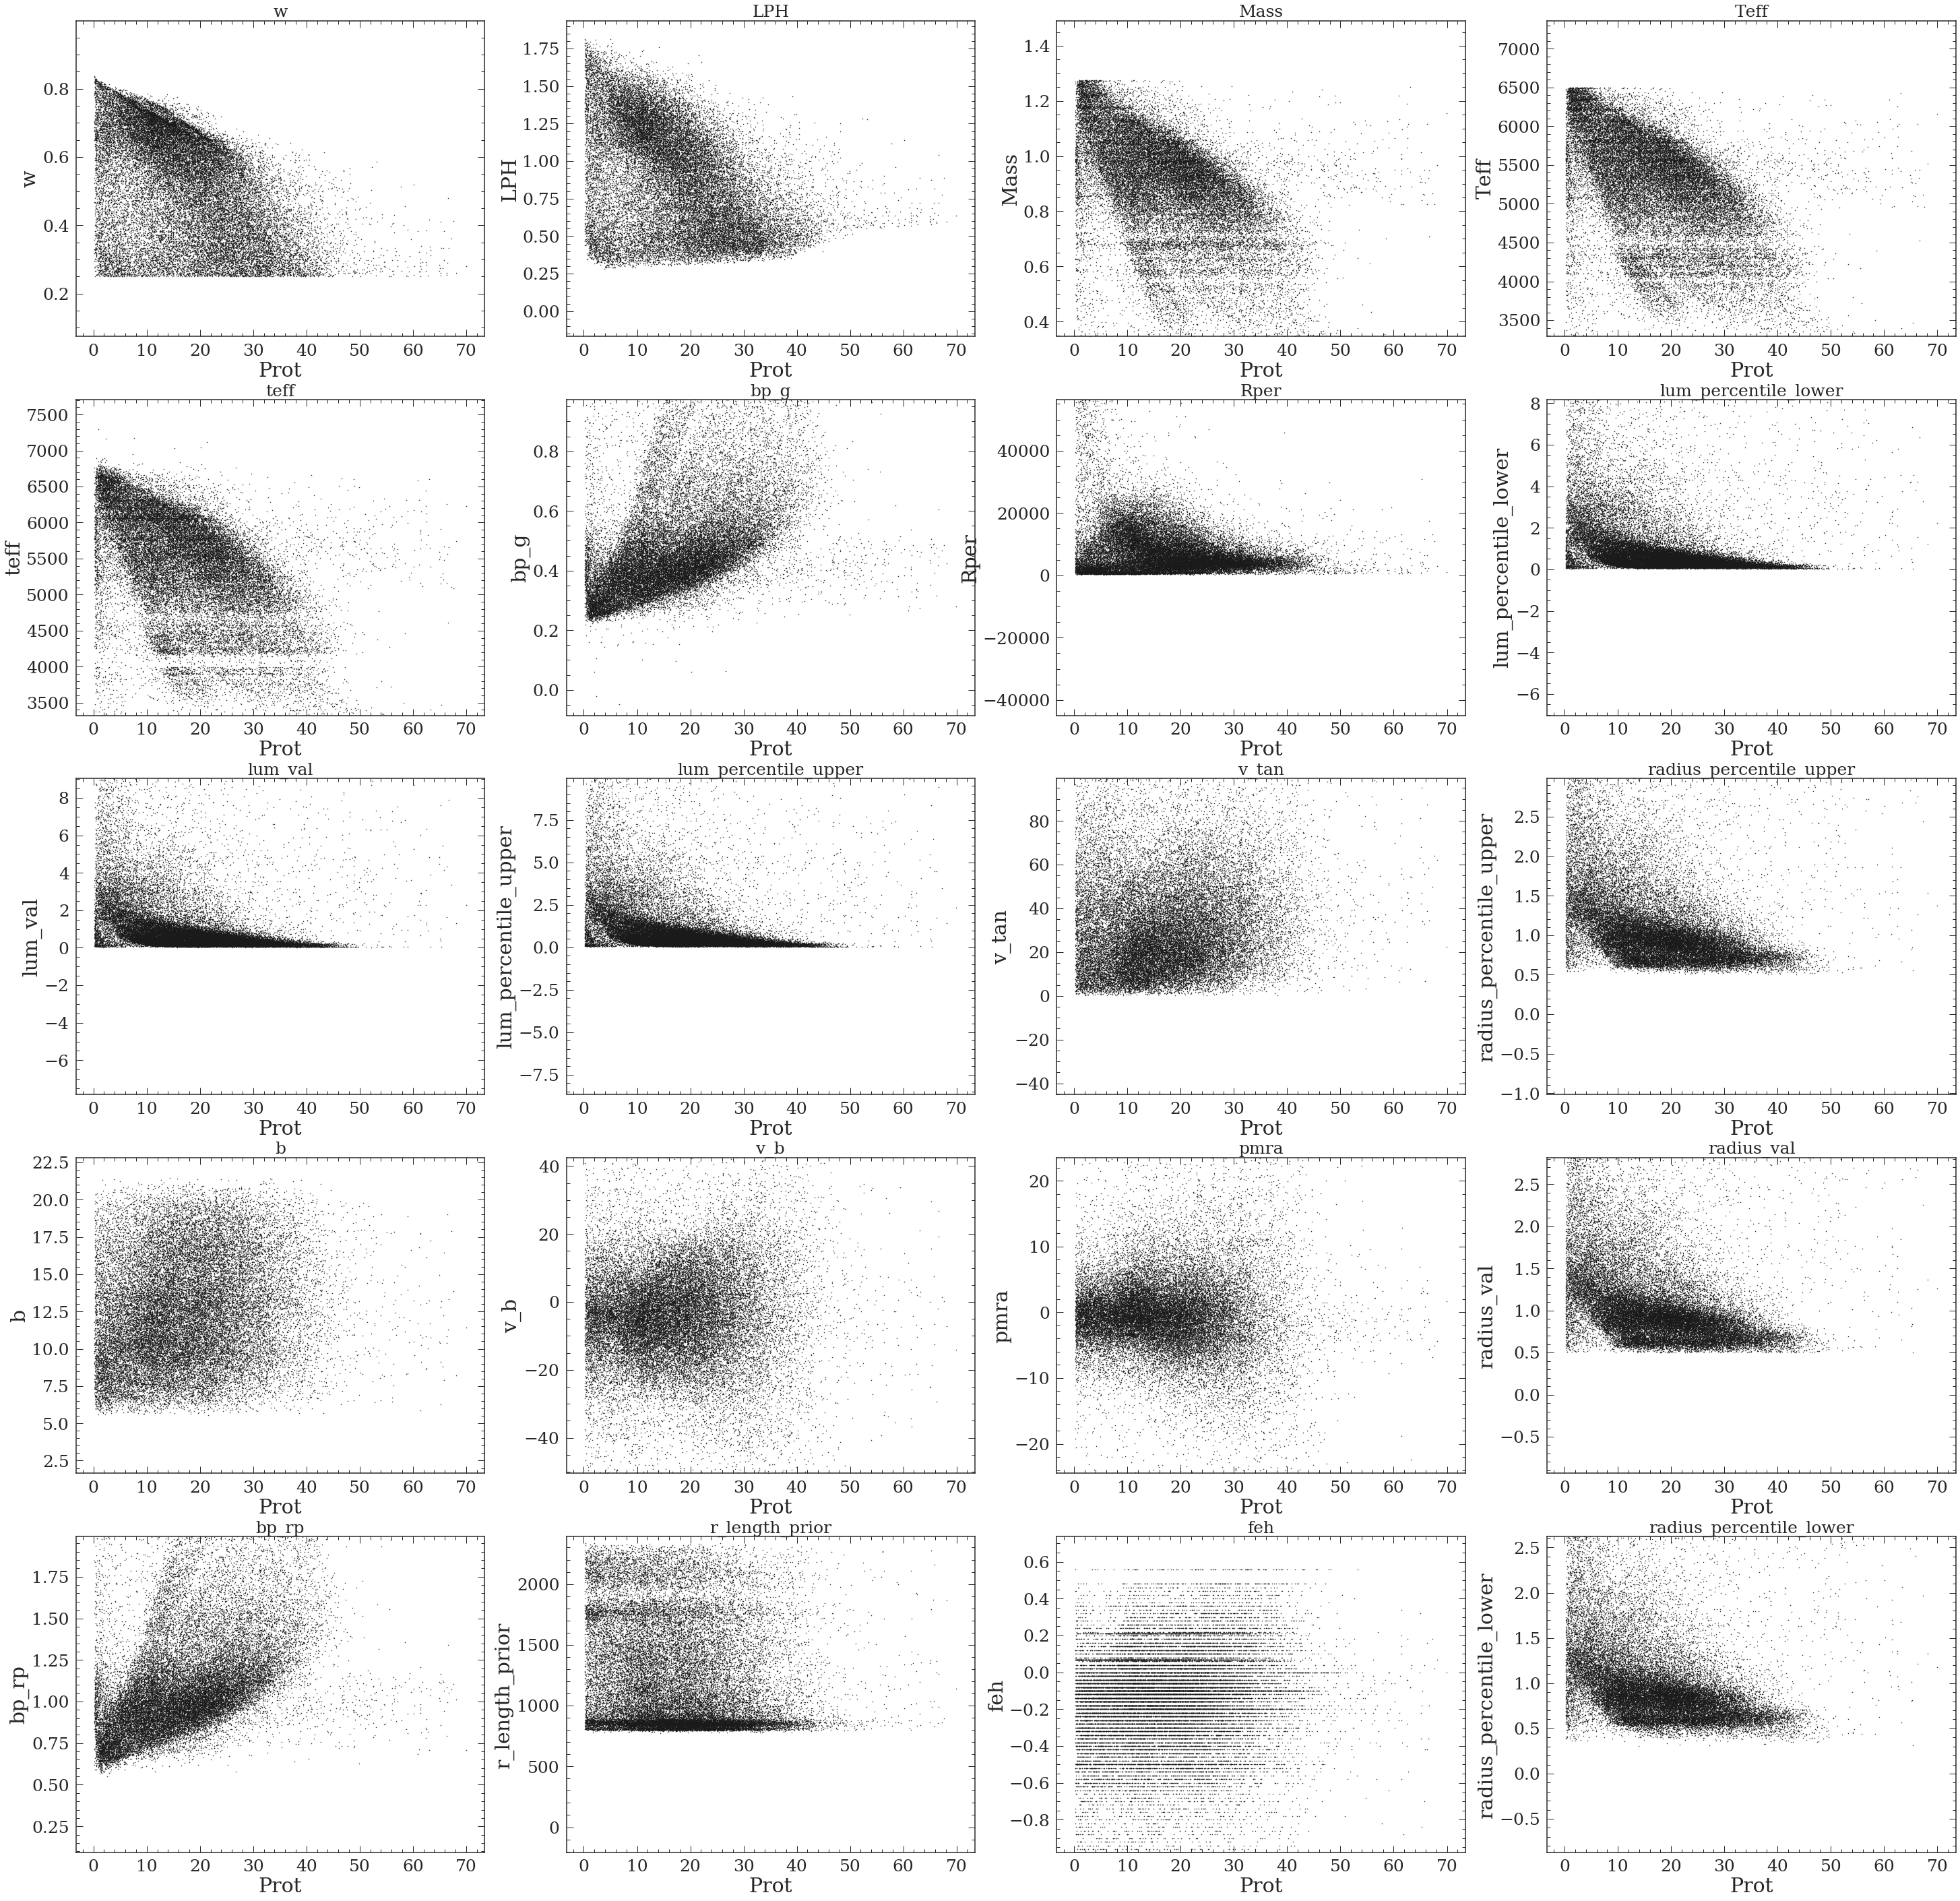

In [322]:
print(x_ticks)
plot_corr(df,x_ticks)

# [4] For results excluding w and LPH since we probably can't get from TESS

In [336]:
# for getting rid of weight and LHP
ignf_2=['w','LPH','Teff','Mass']
flib_w,regr_w,importance_w,actrualF_w,predict_w,X_w,y_test_w,y_test_err_w=my_randF_mask(df,traind,ignf_2)

ignored features ['Prot', 'Prot_err', 'M14', 'C16', 'source_id', 'solution_id', 'gaia_ref_epoch', 'random_index', 'ra_error', 'ntce', 'DC', 'matched_observations', 'kepid', 'w', 'LPH', 'Teff', 'Mass']
Missing 1492 stars to train!


average chisq is:  [1818.01238681]


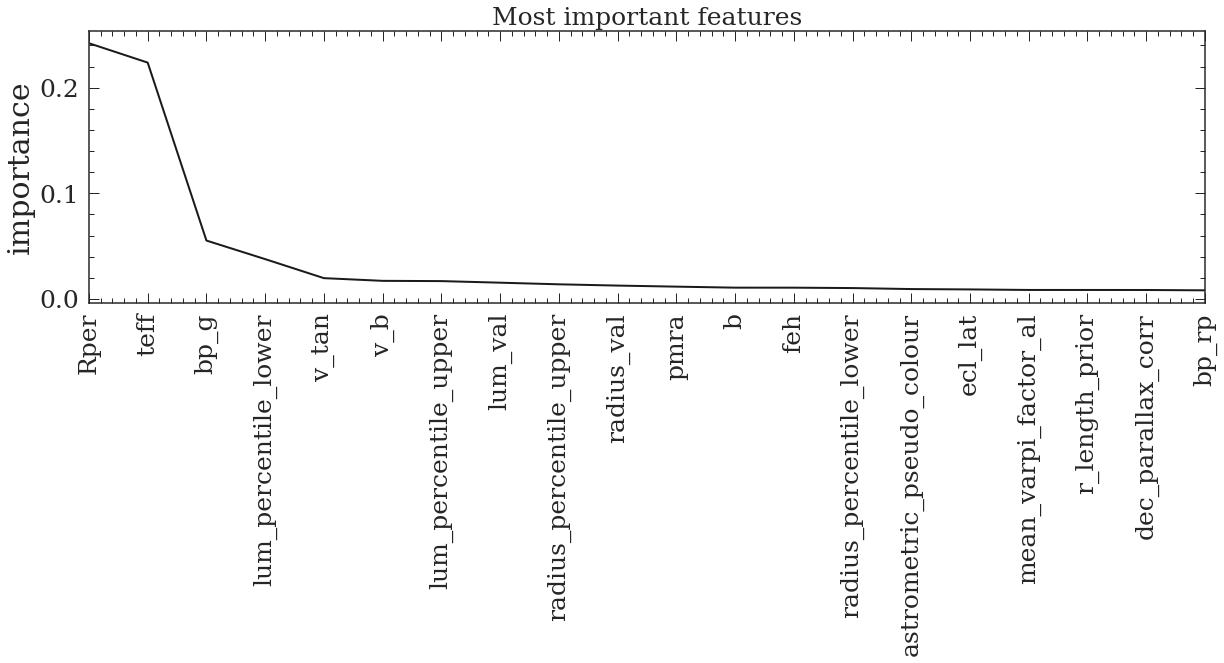

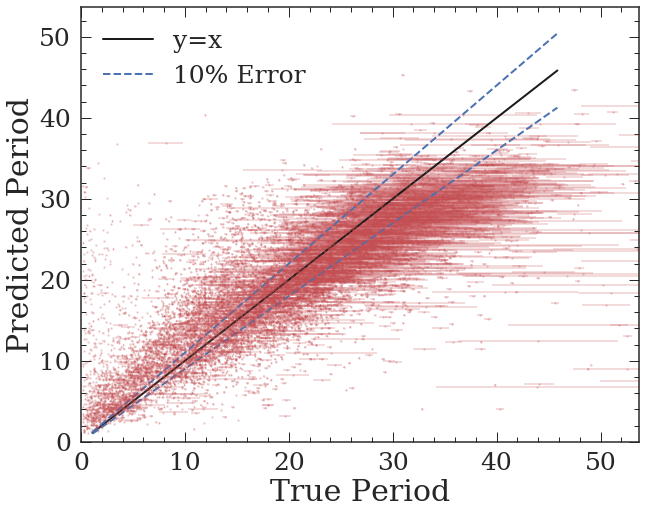

In [337]:
x_ticks_w1=plot_result(actrualF_w,importance_w,predict_w,y_test_w,y_test_err_w)  

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


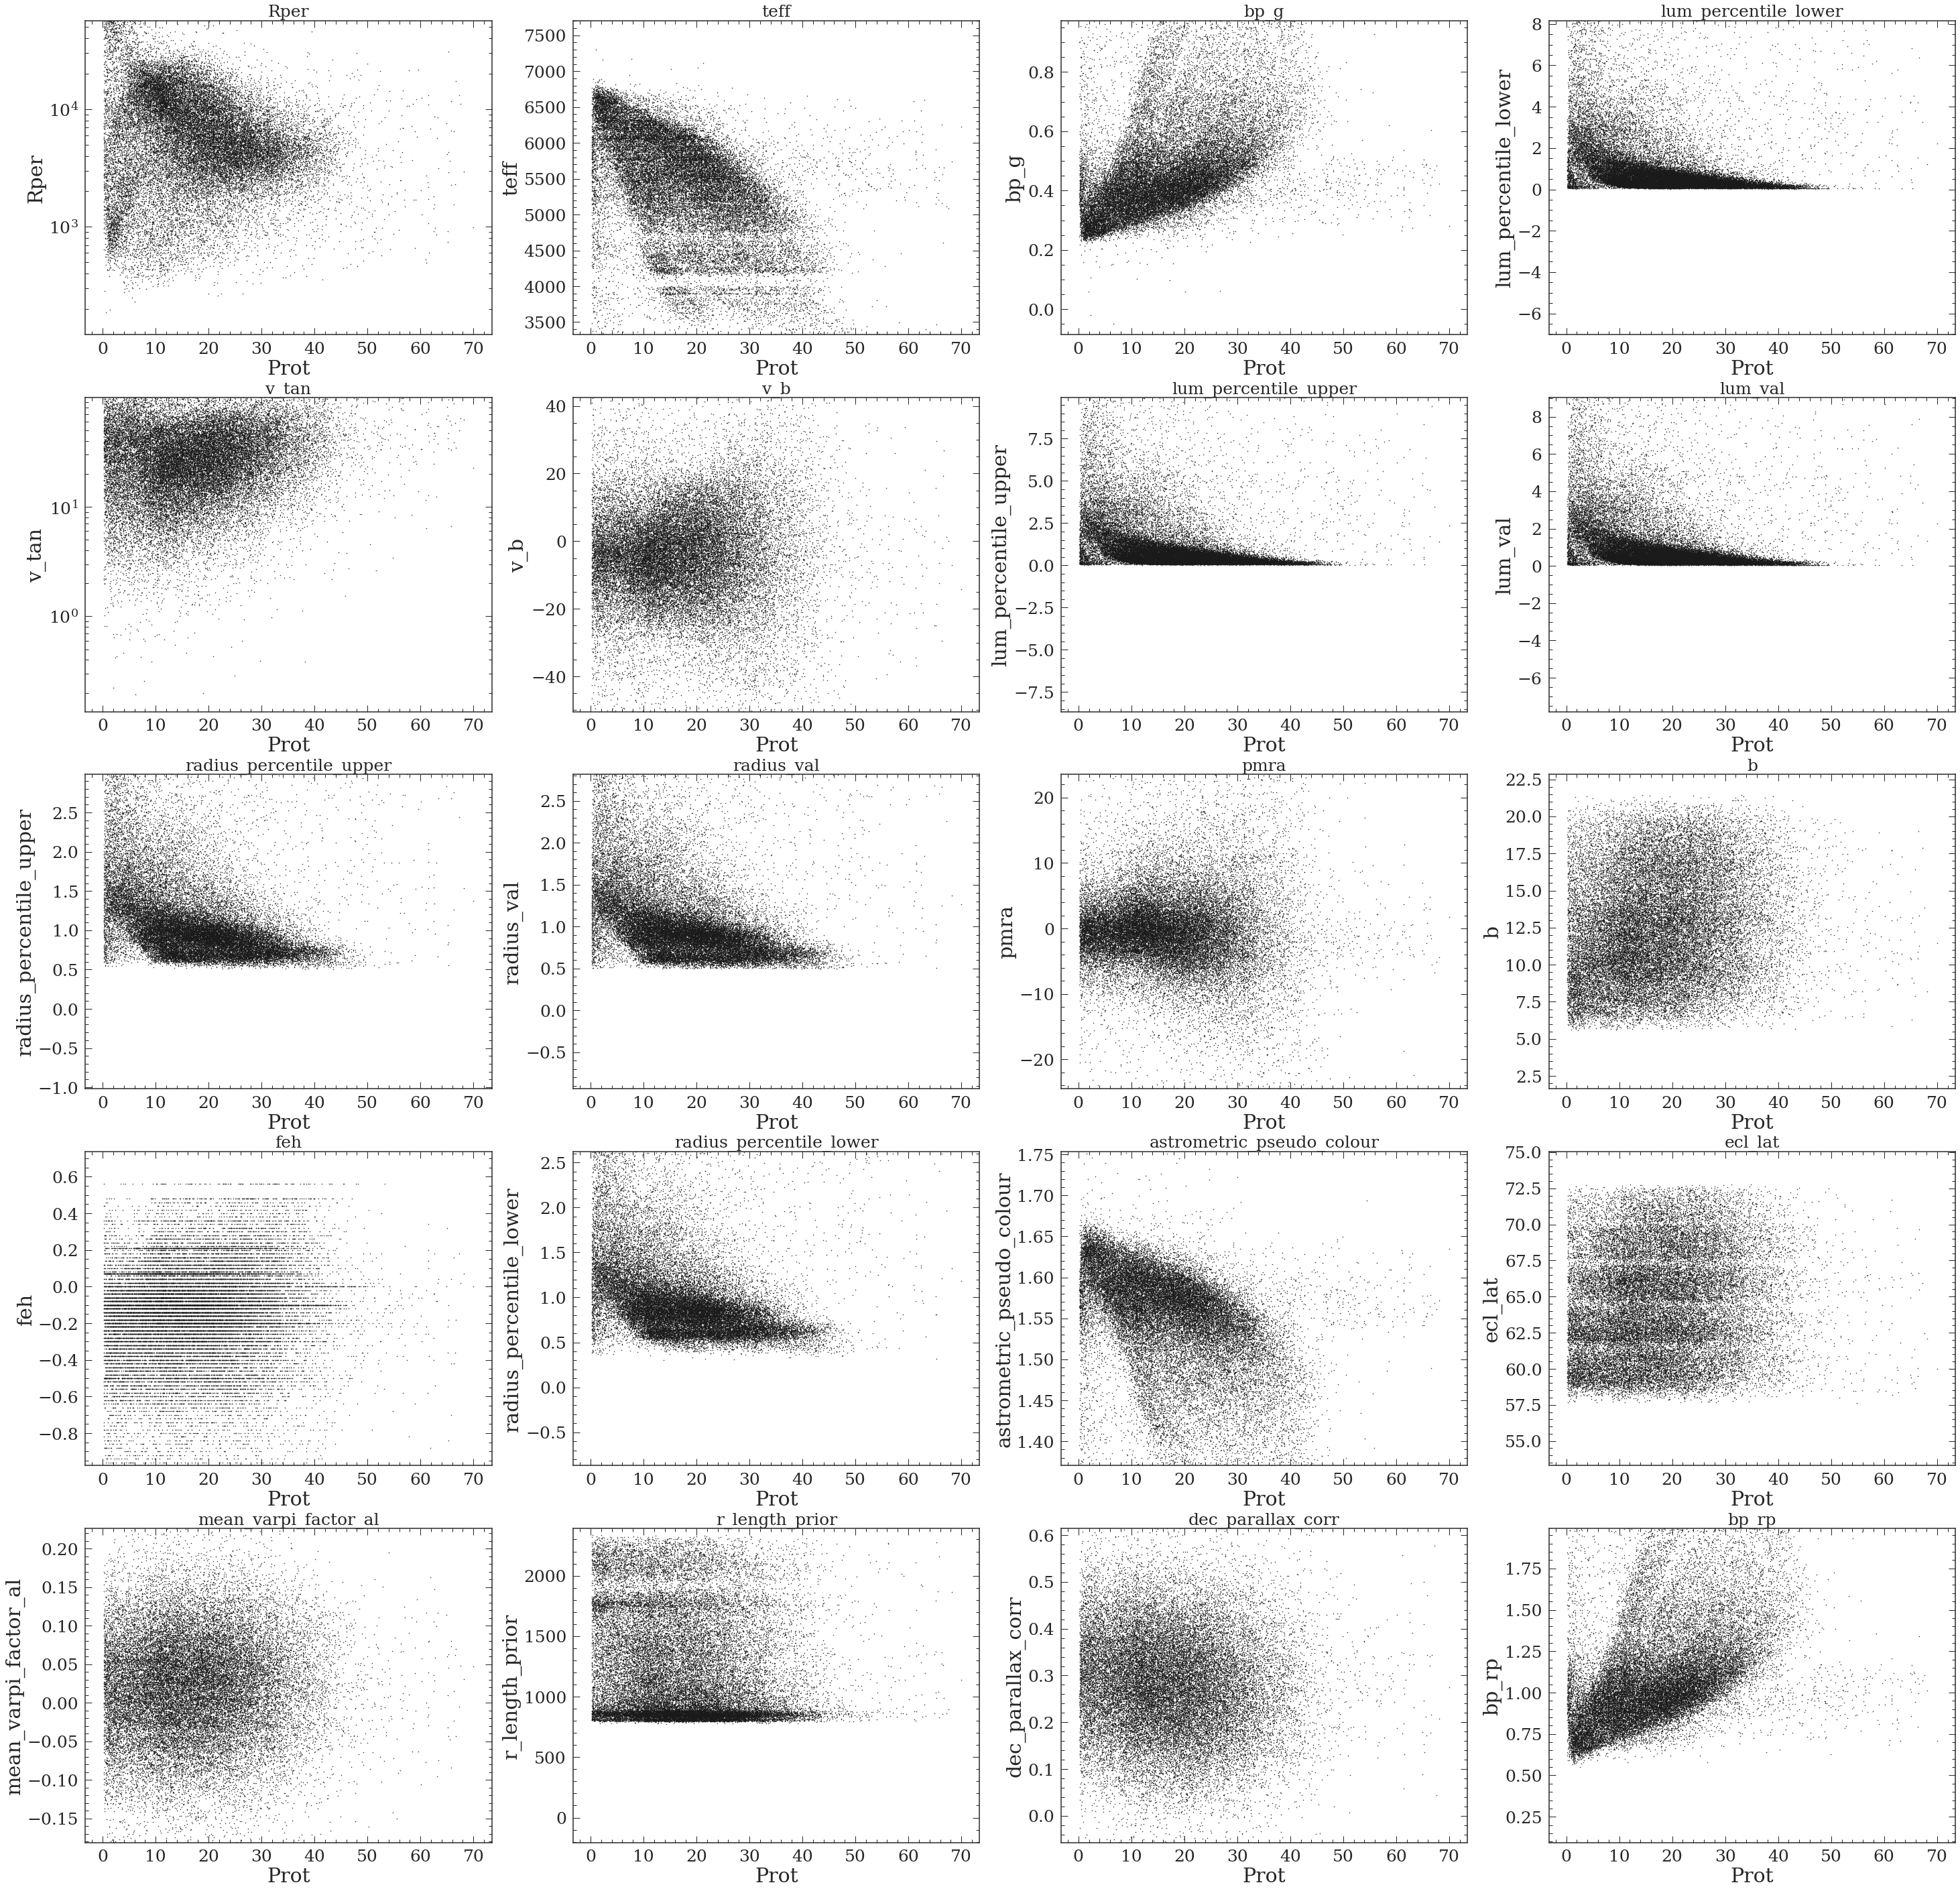

In [338]:
plot_corr(df,x_ticks_w1,['Rper','v_tan'],'logy')

# Compare to linear regression

(32188, 230) 20
(230,) 20
(231,)
importance [('Mass*Teff', 4181.6776764032065), ('Teff*Teff', 3572.50334999013), ('Teff', 1940.9658161153634), ('Mass*Mass', 1177.1403703883316), ('Mass', 1175.8150765652226), ('mass*Teff', 950.8525292610761), ('mass*Mass', 555.0902387309646), ('mass', 417.48654783622646), ('logg_x*Teff', 196.272215466639), ('logg_x*Mass', 133.15186972628695)]
average chisq is:  2680.518899230622


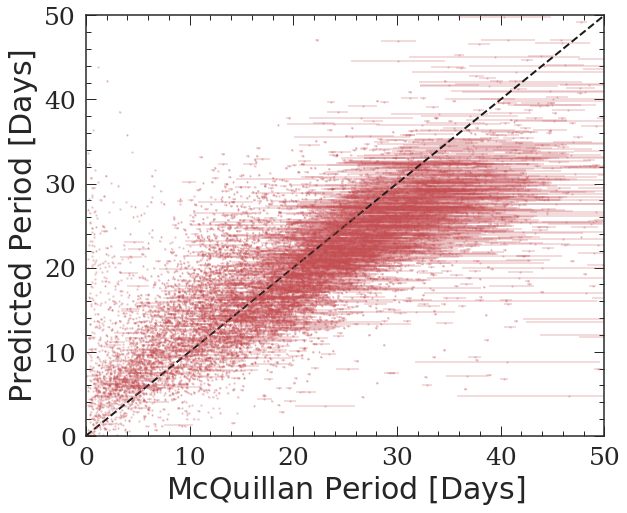

In [122]:
import copy

x_ticks_w=copy.copy(x_ticks_w1)
# create features (no logs)
features = []
logf=['Rper']
normalized=[] # normalized factor

for i in x_ticks_w:
    meddf=np.median(df[i])
    normalized.append(meddf)
    if i in logf:
        features.append(np.log10(df[i]/meddf))
    else:
        features.append(df[i]/meddf)
#print(np.shape(df1), np.shape(df))
'''
x_ticks_w=copy.copy(x_ticks_w1)
#print(x_ticks_w)
# create features (no logs)
features = []
logf=['Rper']
normalized=[] # normalized factor
for i in x_ticks_w:
    norm1f=df[i]-min(df[i]) # no negatives
    print(max(norm1f))
    normalized.append(max(norm1f))
    if i in logf:
        features.append(np.log10(norm1f/max(norm1f)))
        #print(np.log10(norm1f/max(norm1f)))
    else:
        features.append(norm1f/max(norm1f))
        #print(norm1f/max(norm1f))
#print(np.shape(df1), np.shape(df))
'''
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights
y = df.Prot.values
y_err=df.Prot_err.values

from itertools import combinations_with_replacement
'''
args = df["g_i"], df["Mass"], df["Nfl"], df["Nfl68"], df["Lfl_Lkp"], df["alpha"], df["beta"], \
    df["ra"], df["dec"], df["parallax"], 1./df["parallax"], df["abs_G"], df["bprp"], df["pmra"], df["pmdec"]
'''
X = list(features)
for a, b in combinations_with_replacement(features, 2):
    X.append(a * b)
X = np.array(X).T
print(np.shape(X), len(features))


# get names:
for a, b in combinations_with_replacement(x_ticks_w, 2):
    x_ticks_w.append(a +'*'+ b)
print(np.shape(x_ticks_w), len(features))
#print(x_ticks_w)


# Define the number of training and validating stars.
Ntrain = int(traind*len(df.Prot))

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, y_train_err,X_train = y[train_inds], y_err[train_inds],X[train_inds, :]
y_test, y_test_err,X_test = y[test_inds], y_err[test_inds],X[test_inds, :]

weights = train(y_train, X_train)
print(np.shape(weights))
list1=zip(x_ticks_w,abs(weights[1:len(weights)]))
zipimp=sorted(list1, key=lambda x:x[1],reverse=True)
print('importance',zipimp[:10])
      

A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

# calculate chisq
avstedv=calcChi(y_test,y_predict,y_test_err)
print('average chisq is: ',avstedv)
    


plt.figure(figsize=(10, 8))
plt.errorbar(y_test,y_predict.T,xerr=y_test_err,fmt='r.',Markersize=3,alpha=0.2)
plt.plot(sorted(y_test), sorted(y_test), "k--")
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("$\mathrm{McQuillan~Period~[Days]}$")
plt.ylabel("$\mathrm{Predicted~Period~[Days]}$")
plt.subplots_adjust(left=.18, bottom=.15)
#plt.savefig('Linear.png')

# [5] Feature Engineering

In [433]:
def my_randF_SL(df,traind,testF,chisq_out=0):
    #	my_randF_SL(df,traind,testF,chisq_out=0) [random forest that only uses only input features]
    #		df: the data
    #		traind: what fraction of data use to train
    #		testF: list of features to use
    #		chisq_out: only output chisq (1) or not (0)
    #		
    #		outputs: 
    #			flib: lib for features indexed
    # 			regr: trained model
    # 			importance: importance of features
    # 			actrualF: actrual feature used
    # 			predictp: predicted periods
    #			X_test: feature matrix used to predicts
    #			y_test(y_test_err): labels(error) array used to test predictions
    #			avstedv: average chi^2 for prediction

    #print('flib,regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)')
    #print(df)
    #print(traind)
    #print(testF)
    fl=len(df.columns) # how many features
    keys=range(fl)
    flib=dict(zip(keys, df.columns))
    
    featl_o=len(df.Prot) # old feature length before dropping
    
    actrualF=[] # actrual feature used
    # fill in feature array
    lenX=0
    actrualF=[]
    for i in df.columns:
        feature=df[i].values
        if (type(feature[0]) is not str) and (i in testF) and sum(np.isnan(feature))<0.05*featl_o:
            #if (np.isnan(feature).any()):
            #    print(i)
            #    print(feature[np.isnan(feature)])
            lenX=lenX+1
            actrualF.append(i)
            
    X=df[actrualF]
    X=X.replace([np.inf, -np.inf], np.nan)
    X=X.dropna()
    featl=np.shape(X)[0]
    if (featl_o-featl)!=0:
        print('Missing '+ str(featl_o-featl)+' stars to train!')
    
    Ntrain = int(traind*featl)

    # output
    y=df.Prot[X.index].values
    y_err=df.Prot_err[X.index].values
    X=X.values
    
    # Choose stars at random and split.
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
    train_inds = shuffle_inds[:Ntrain]
    test_inds = shuffle_inds[Ntrain:]
    y_train, y_train_err,X_train = y[train_inds], y_err[train_inds],X[train_inds, :]
    y_test, y_test_err,X_test = y[test_inds], y_err[test_inds],X[test_inds, :]


    # run random forest
    regr = RandomForestRegressor(random_state=0,n_estimators=100)
    regr.fit(X_train, y_train)  

    # get the importance of each feature
    importance=regr.feature_importances_
    
    # make prediction
    predictp=np.zeros([len(X_test),1]) # predicted period
    difc=0
    for i in range(len(X_test)):
        predictp[difc]=regr.predict([X_test[i,:]])
        difc=difc+1
    
    # calculate chisq
    avstedv=calcChi(y_test,predictp,y_test_err)
    
    if chisq_out==1:
        return avstedv
    else:
        return flib,regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv



# Use Gaia temp compare to use McQuillan temp

In [384]:
#print(actrualF_w)
#print(importance_w)

list1 = list(zip(actrualF_w,importance_w))
# sort the zipped list
decend=sorted(list1, key=lambda x:x[1],reverse=True)
de_F,de_I=zip(*decend) # unzip
#print(de_F)
# mcquillan temp
de_F_MC=[i for i in de_F if i!='teff']
de_F_MC=np.append(de_F_gaia,['Teff'])
#print(de_F_gaia)

flib_gaia,regr_gaia,importance_gaia,actrualF_gaia,predictp_gaia,X_gaia,y_test_gaia,y_test_err_gaia,avstedv_gaia=my_randF_SL(df,traind,de_F)
print('Gaia Temp/Mass chisq:',avstedv_gaia)
# McQuillan temp and mass
flib_MC,regr_MC,importance_MC,actrualF_MC,predictp_MC,X_MC,y_test_MC,y_test_err_MC,avstedv_MC=my_randF_SL(df,traind,de_F_MC)
print('MC Temp/Mass chisq:',avstedv_MC)

Missing 1492 stars to train!
Gaia Temp/Mass chisq: [1707.16703072]
Missing 1492 stars to train!
MC Temp/Mass chisq: [1828.57251557]


results very similar

average chisq is:  [1704.57170675]
average chisq is:  [1825.39549741]


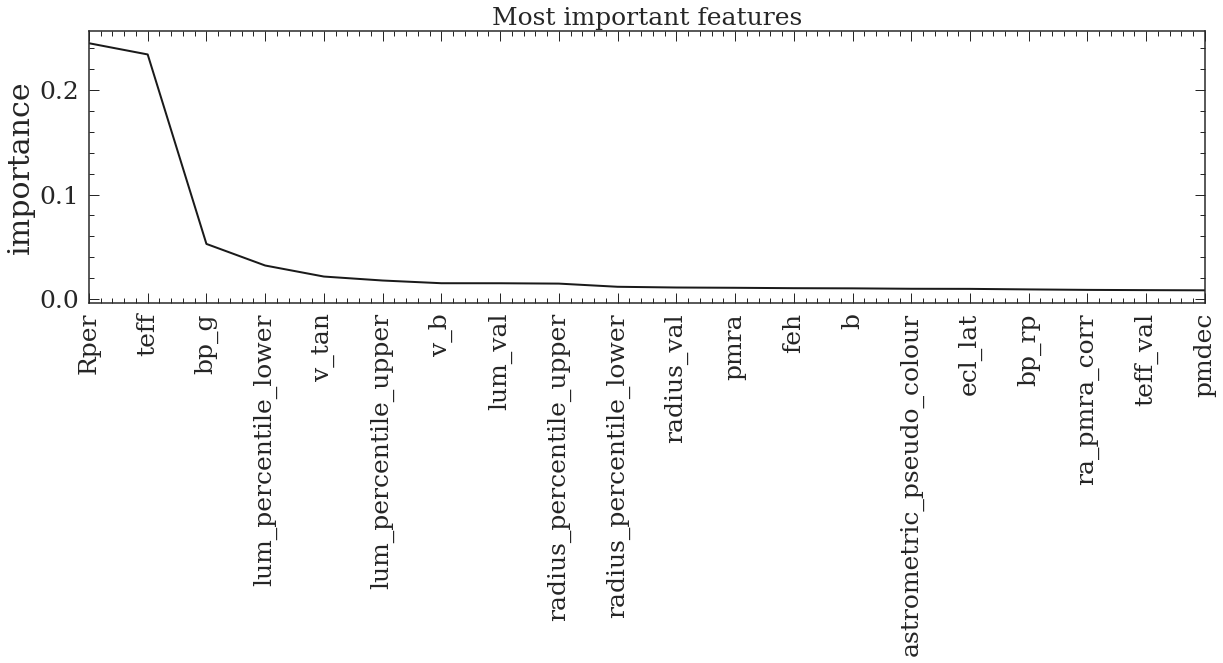

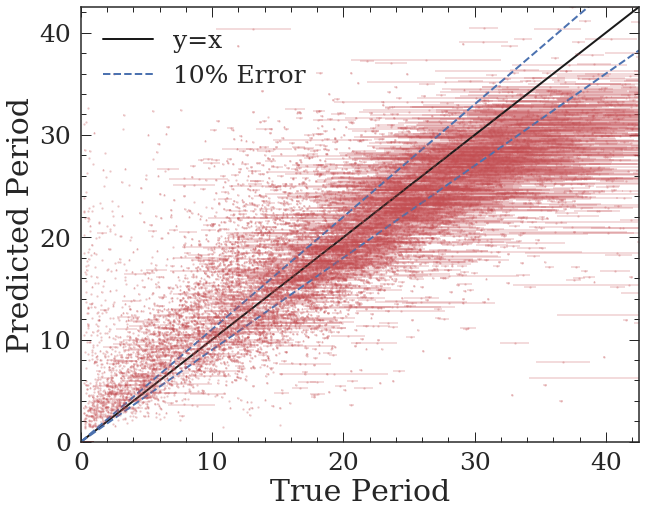

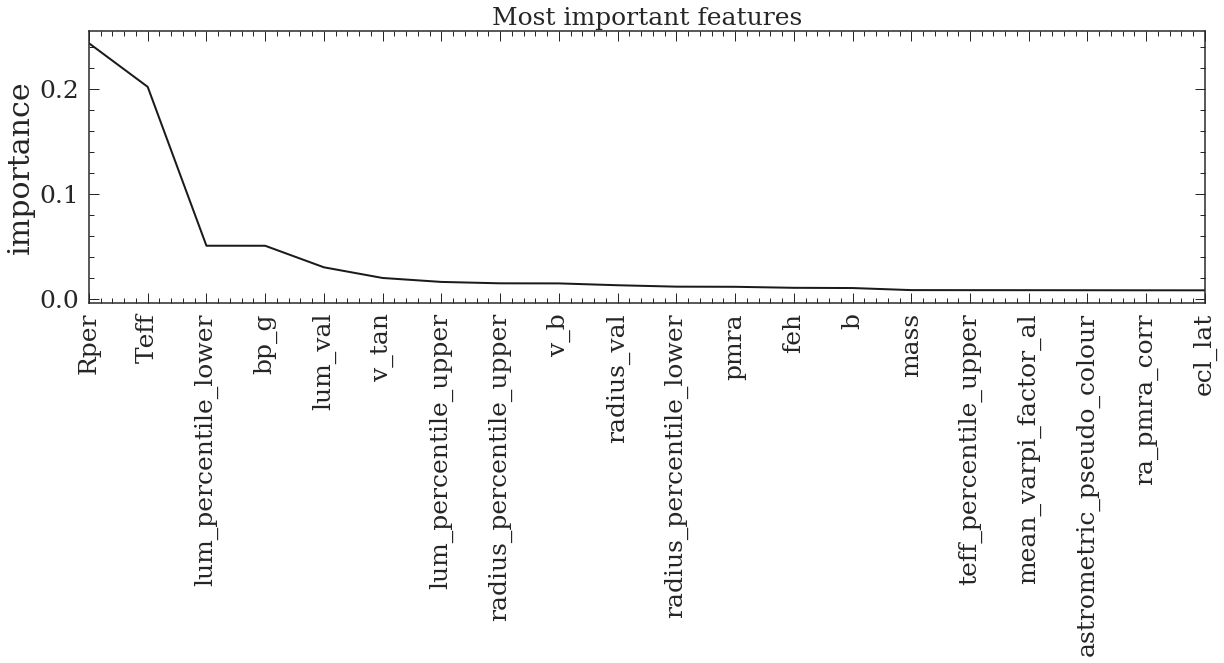

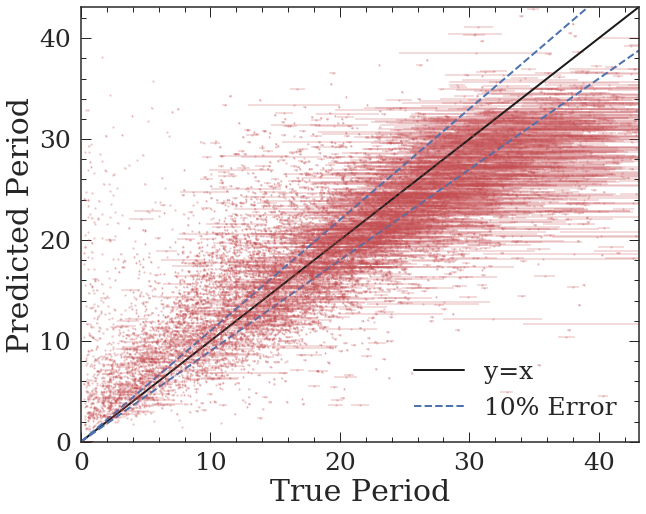

In [393]:
# plot predict vs true
x_ticks_gaia=plot_result(actrualF_gaia,importance_gaia,predictp_gaia,y_test_gaia,y_test_err_gaia,min([20,len(de_F)]))  
x_ticks_MC=plot_result(actrualF_MC,importance_MC,predictp_MC,y_test_MC,y_test_err_MC,min([20,len(de_F_MC)])) 

# Get optimum # of features

In [339]:
featl=len(df.Prot)
Prot_test=df.Prot.values[int(traind*featl)+1:featl]
Prot_test_err=df.Prot_err.values[int(traind*featl)+1:featl]

chisq_a=[]
chisq_a_err=[]
for i in range(3,40):
    chisq_ave=[] # use for calculating average
    print('i',i)
    for j in range(10): # test 10 times for each
        print('j',j)
        chisq_ave.append(my_randF_SL(df,traind,de_F[:i],1))
    chisq_a.append(np.mean(chisq_ave))
    chisq_a_err.append(np.std(chisq_ave))

i 3
j 0
Missing 5 stars to train!
j 1
Missing 5 stars to train!
j 2
Missing 5 stars to train!
j 3
Missing 5 stars to train!
j 4
Missing 5 stars to train!
j 5
Missing 5 stars to train!
j 6
Missing 5 stars to train!
j 7
Missing 5 stars to train!
j 8
Missing 5 stars to train!
j 9
Missing 5 stars to train!
i 4
j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to train!
j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!
i 5
j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to train!
j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!
i 6
j 0
Missing 1492 stars t

j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!
i 28
j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to train!
j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!
i 29
j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to train!
j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!
i 30
j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to tr

optimum # important features:  13 ('Rper', 'teff', 'bp_g', 'lum_percentile_lower', 'v_tan', 'v_b', 'lum_percentile_upper', 'lum_val', 'radius_percentile_upper', 'radius_val', 'pmra', 'b', 'feh')


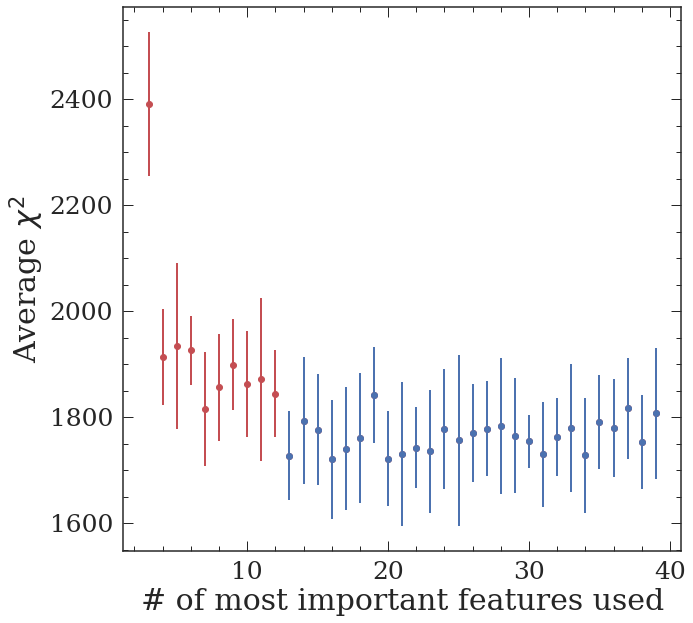

In [342]:
#np.save('averagechisq', chisq_a)
#np.save('averagechisq_err', chisq_a_err)
#print(chisq_a)
medchisq=np.median(chisq_a)
for i in range(len(chisq_a)):
    if chisq_a[i]<medchisq:
        NF=i
        break
    

plt.figure()
plt.errorbar(range(3,40),chisq_a,yerr=chisq_a_err,fmt='ro')
plt.errorbar(range(NF+3,40),chisq_a[NF:],yerr=chisq_a_err[NF:],fmt='bo')
plt.ylabel('Average $\chi^2$')
plt.xlabel('# of most important features used')
print('optimum # important features: ',NF+3,de_F[:(NF+3)])

optF=de_F[:(NF+3)] # features used

# plot correlations 

/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


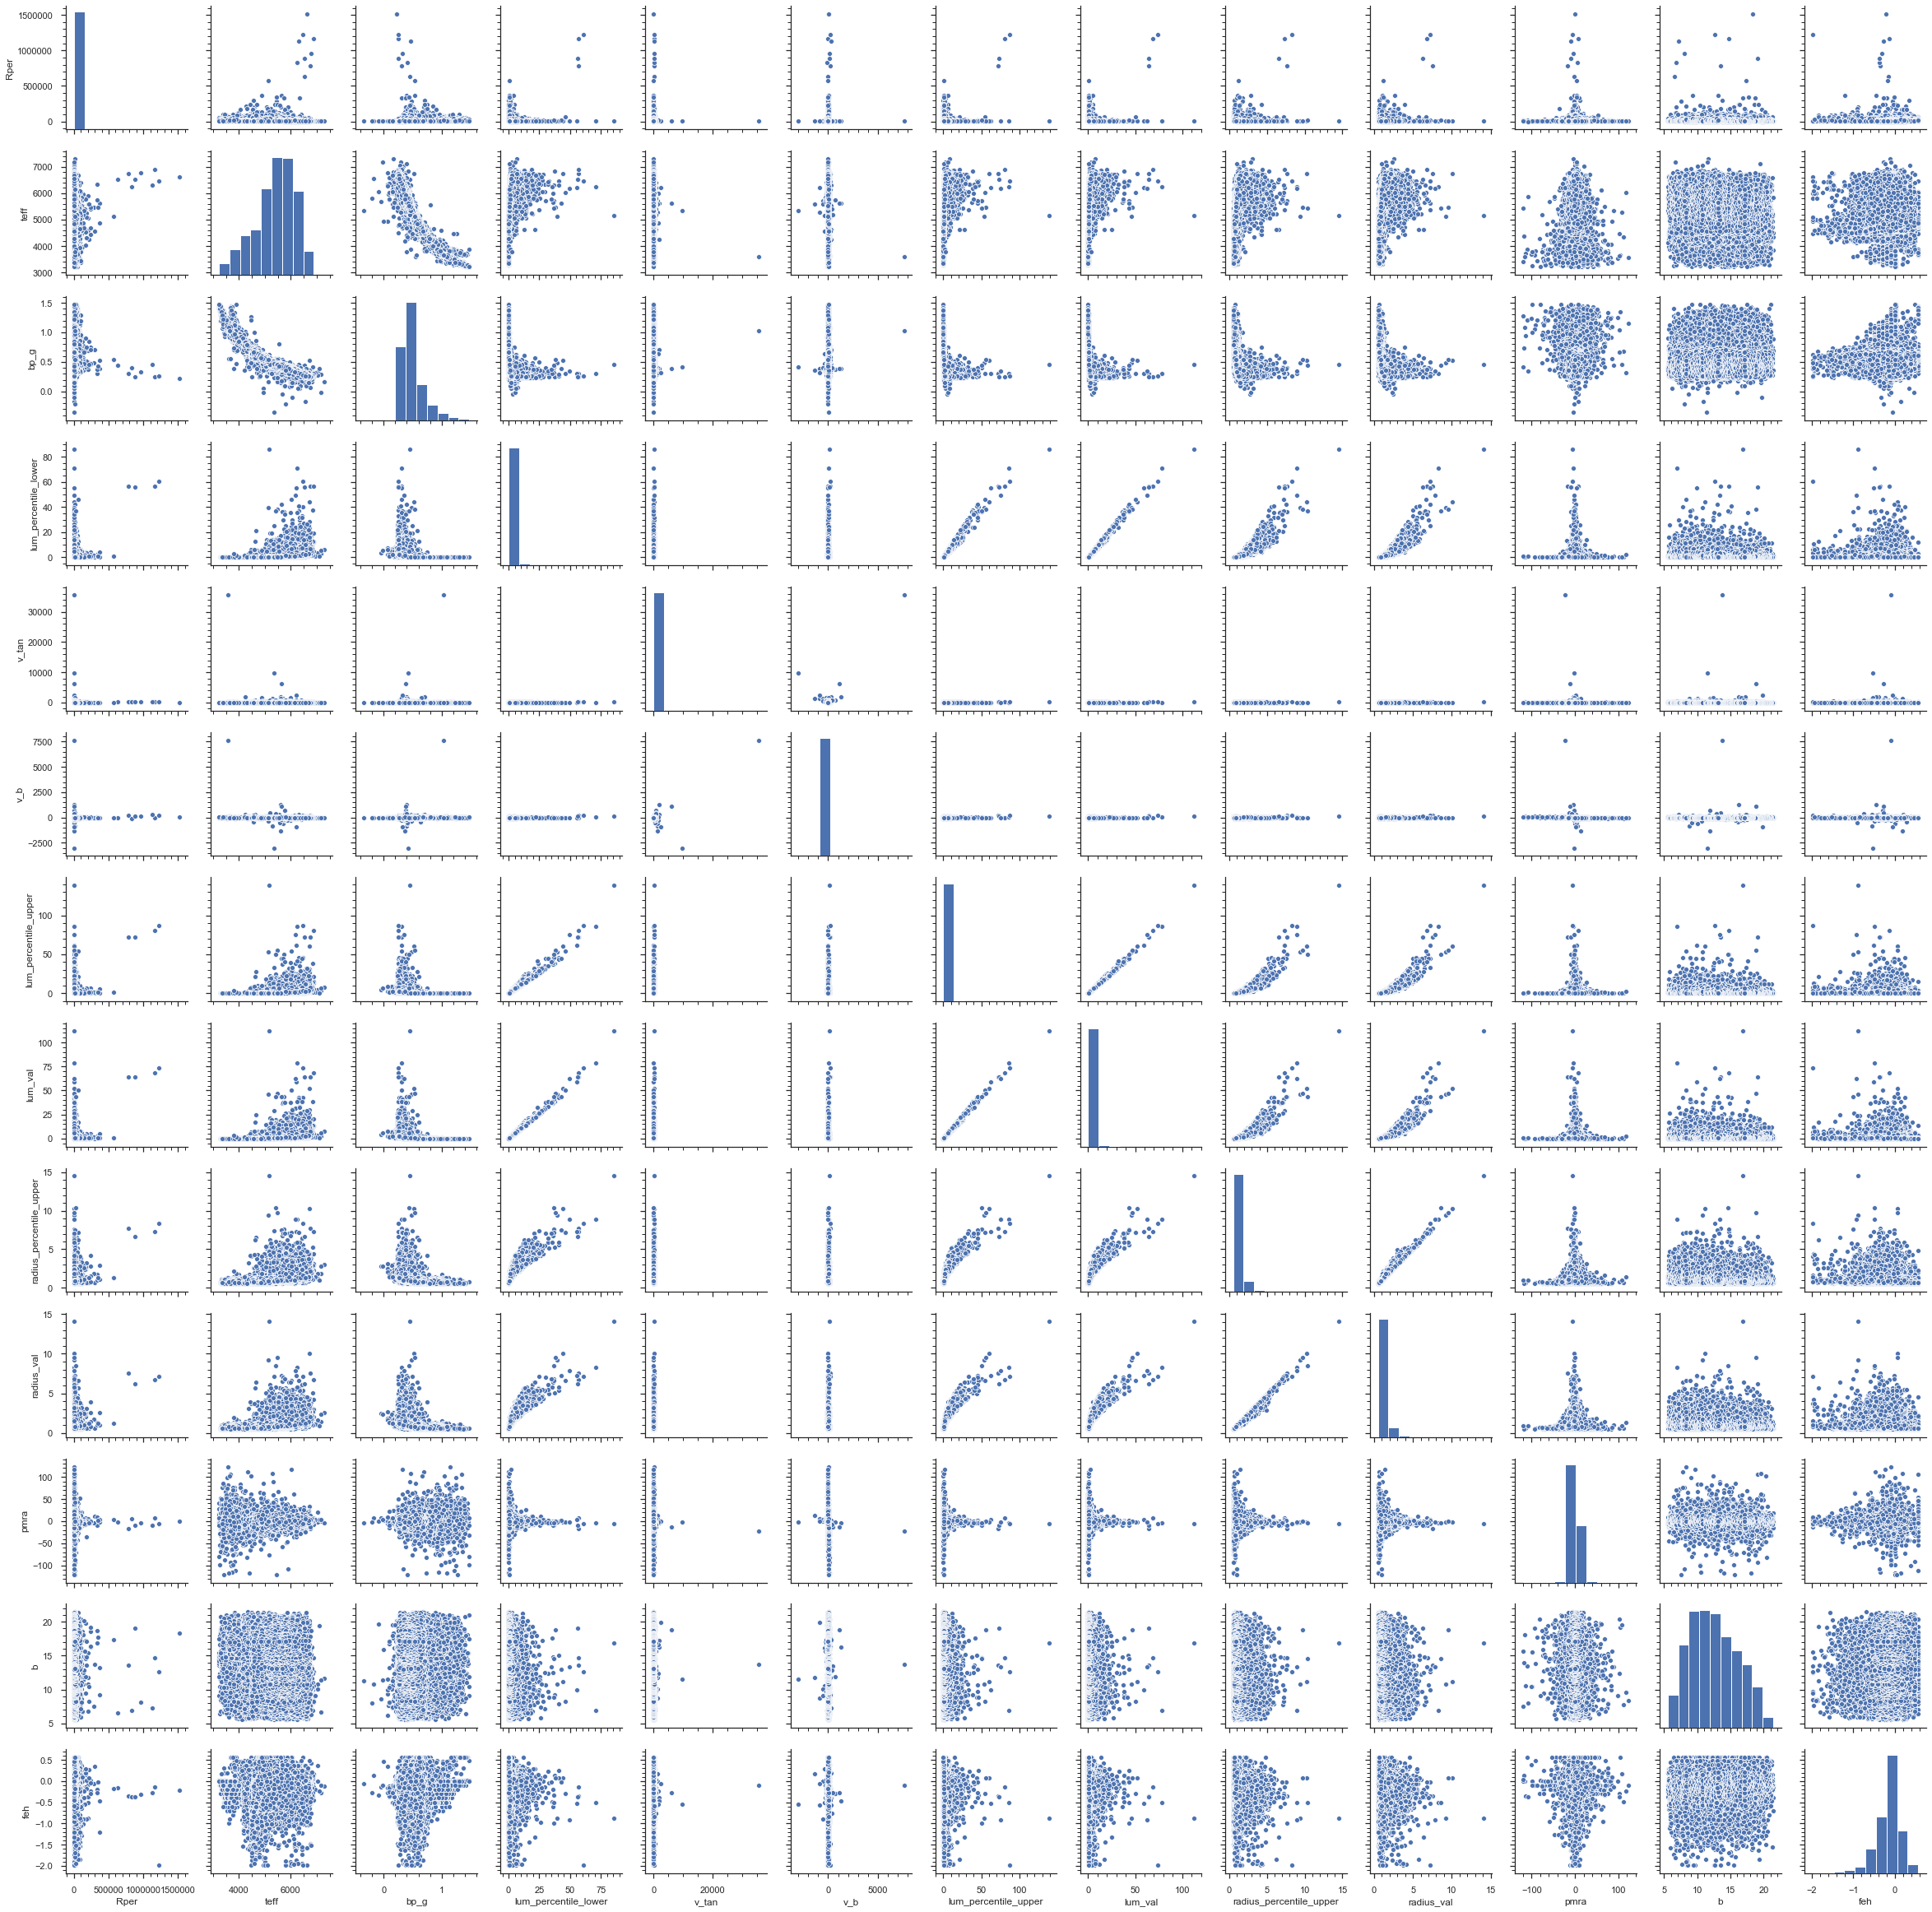

In [343]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
iris = df[list(optF)]
#print(iris)
# correlations between these features
g = sns.pairplot(iris)

# Test with lum_percentile_uper and lum_percentile_lower taken out (very correlated)

In [415]:
optF=de_F[:(NF+3)] # features used
print(optF)

import time
time_a=[]
# take out both
optF_woTeff=[i for i in optF if (i!='lum_percentile_upper' and i!='lum_percentile_lower')]
print(optF_woTeff)

chisq_ave=[] # use for calculating average
for j in range(10): # test 10 times for each
    print('j',j)
    start = time.time() # time function
    chisq_ave.append(my_randF_SL(df,traind,optF_woTeff,1))
    end = time.time() # time function
    time_a.append(end-start)
chisq_noTeff=np.mean(chisq_ave)
chisq_noTeff_err=np.std(chisq_ave)
time_wo=np.mean(time_a)
time_wo_err=np.std(time_a)


('Rper', 'teff', 'bp_g', 'lum_percentile_lower', 'v_tan', 'v_b', 'lum_percentile_upper', 'lum_val', 'radius_percentile_upper', 'radius_val', 'pmra', 'b', 'feh')
['Rper', 'teff', 'bp_g', 'v_tan', 'v_b', 'lum_val', 'radius_percentile_upper', 'radius_val', 'pmra', 'b', 'feh']


"\nchisq_ave=[] # use for calculating average\nfor j in range(10): # test 10 times for each\n    print('j',j)\n    start = time.time() # time function\n    chisq_ave.append(my_randF_SL(df,traind,optF_woTeff,1))\n    end = time.time() # time function\n    time_a.append(end-start)\nchisq_noTeff=np.mean(chisq_ave)\nchisq_noTeff_err=np.std(chisq_ave)\ntime_wo=np.mean(time_a)\ntime_wo_err=np.std(time_a)\n"

In [352]:
# time with all features
time_a=[]
# take out both
chisq_ave=[] # use for calculating average
for j in range(10): # test 10 times for each
    print('j',j)
    start = time.time() # time function
    chisq_ave.append(my_randF_SL(df,traind,optF,1))
    end = time.time() # time function
    time_a.append(end-start)
time_all=np.mean(time_a)
time_all_err=np.std(time_a)


j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to train!
j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!


In [416]:
optF_f=optF_woTeff # these are the optimum feature to use
print('Feature length:',len(optF_f))
print(optF_f)

Feature length: 11
['Rper', 'teff', 'bp_g', 'v_tan', 'v_b', 'lum_val', 'radius_percentile_upper', 'radius_val', 'pmra', 'b', 'feh']


# Test with lum_percentile_uper and lum_percentile_lower taken out (very correlated) but add phot_g_mean_flux_error

The error should affect how accurate the model is

In [417]:
optF_f_e=np.append(optF_f,'phot_g_mean_flux_error') #rerun without taking out errros and this is the most important error
print(optF_f_e)
# time with all features
time_a=[]
chisq_ave=[] # use for calculating average
for j in range(10): # test 10 times for each
    print('j',j)
    start = time.time() # time function
    chisq_ave.append(my_randF_SL(df,traind,optF_f_e,1))
    end = time.time() # time function
    time_a.append(end-start)
chisq_we=np.mean(chisq_ave)
chisq_we_err=np.std(chisq_ave)
time_we=np.mean(time_a)
time_we_err=np.std(time_a)


['Rper' 'teff' 'bp_g' 'v_tan' 'v_b' 'lum_val' 'radius_percentile_upper'
 'radius_val' 'pmra' 'b' 'feh' 'phot_g_mean_flux_error']
j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to train!
j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!


Get rid of radius bound

In [435]:
optF_f_nothing=[i for i in optF if (i!='radius_percentile_upper' and i!='lum_percentile_lower' and i!='lum_percentile_upper')]
print(optF_f_nothing)
# time with all features
time_a=[]
chisq_ave=[] # use for calculating average
for j in range(10): # test 10 times for each
    print('j',j)
    start = time.time() # time function
    chisq_ave.append(my_randF_SL(df,traind,optF_f_e,1))
    end = time.time() # time function
    time_a.append(end-start)
chisq_nt=np.mean(chisq_ave)
chisq_nt_err=np.std(chisq_ave)
time_nt=np.mean(time_a)
time_nt_err=np.std(time_a)



['Rper', 'teff', 'bp_g', 'v_tan', 'v_b', 'lum_val', 'radius_val', 'pmra', 'b', 'feh']
j 0
Missing 1492 stars to train!
j 1
Missing 1492 stars to train!
j 2
Missing 1492 stars to train!
j 3
Missing 1492 stars to train!
j 4
Missing 1492 stars to train!
j 5
Missing 1492 stars to train!
j 6
Missing 1492 stars to train!
j 7
Missing 1492 stars to train!
j 8
Missing 1492 stars to train!
j 9
Missing 1492 stars to train!


Probably not worth adding anything... Just use all-r/lum_boudns
Feature length: 10
['Rper', 'teff', 'bp_g', 'v_tan', 'v_b', 'lum_val', 'radius_val', 'pmra', 'b', 'feh']


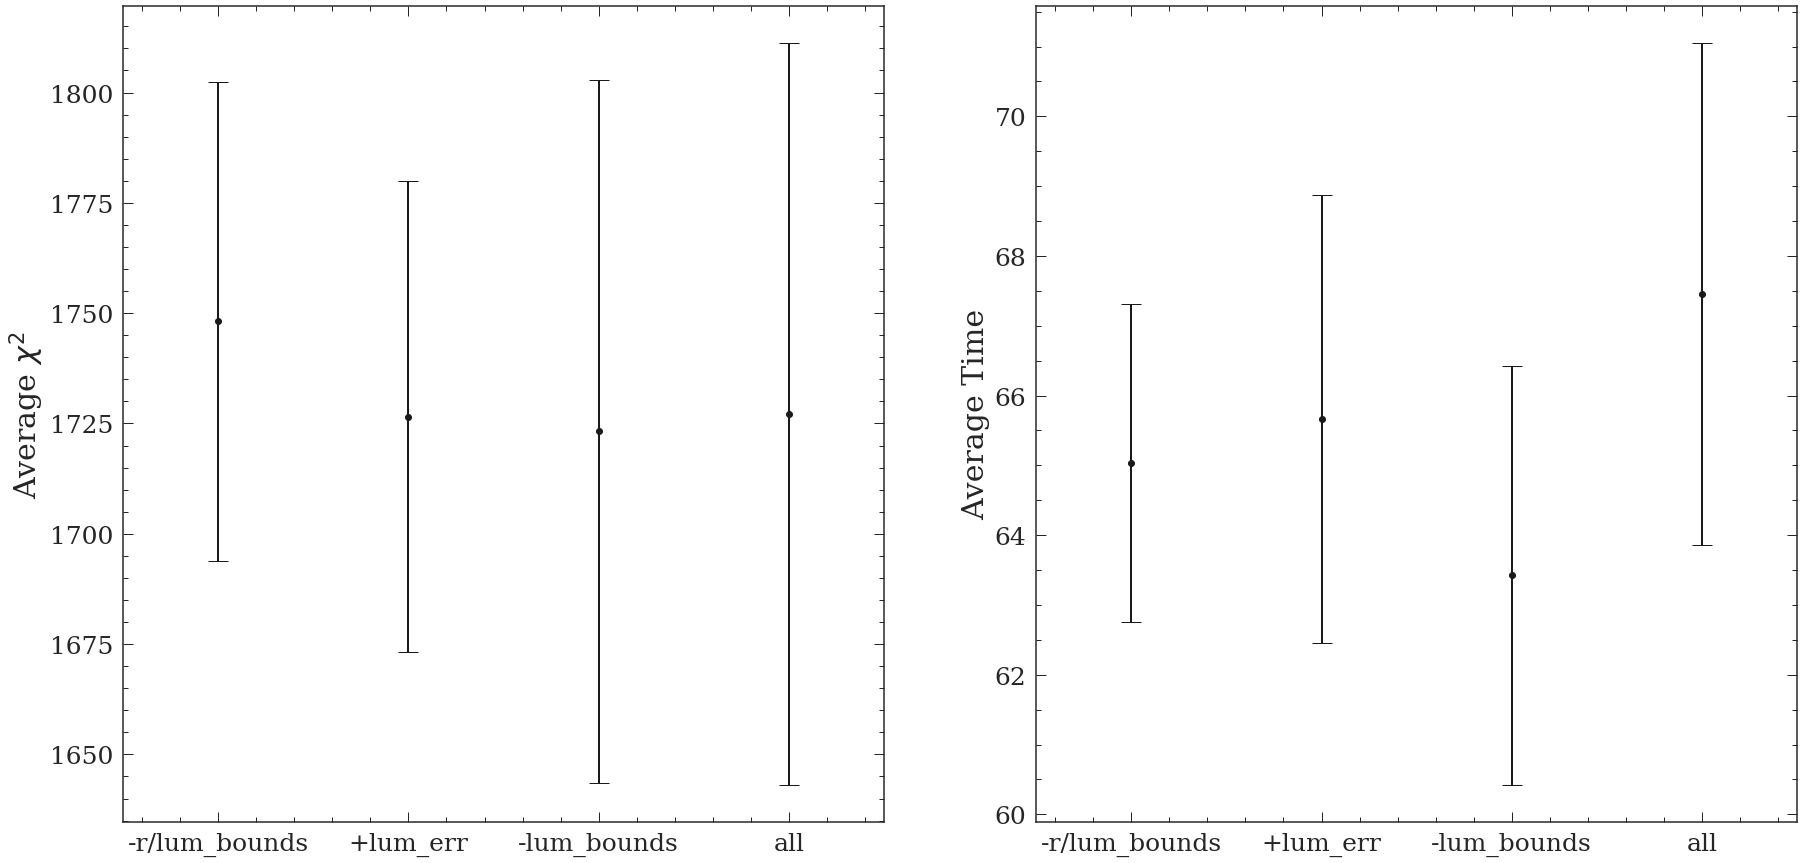

In [437]:
#chisq_a=np.load('averagechisq.npy')
#chisq_a_err=np.load('averagechisq_err.npy')
#print(chisq_a)
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
my_xticks=['-r/lum_bounds','+lum_err','-lum_bounds','all']
plt.errorbar([0,1,2,3],[chisq_nt,chisq_we,chisq_noTeff,chisq_a[NF]],yerr=[chisq_nt_err,chisq_we_err,chisq_noTeff_err,chisq_a_err[NF]],fmt='ko',barsabove=True,capsize=10)
plt.xlim([-0.5,3.5])
plt.xticks([0,1,2,3], my_xticks)
plt.ylabel('Average $\chi^2$')

plt.subplot(1,2,2)
plt.errorbar([0,1,2,3],[time_nt,time_we,time_wo,time_all],yerr=[time_nt_err,time_we_err,time_wo_err,time_all_err],fmt='ko',barsabove=True,capsize=10)
plt.xlim([-0.5,3.5])
plt.xticks([0,1,2,3], my_xticks)
plt.ylabel('Average Time')  
'''
plt.figure()
plt.errorbar([0,1],[chisq_a[NF],chisq_noTeff],yerr=[chisq_a_err[NF],chisq_noTeff_err],fmt='ko')
my_xticks=['all','w/o lum_bounds']
plt.xticks([0,1], my_xticks)
plt.xlim([-1,2])
plt.ylabel('Average $\chi^2$')
'''
print('Probably not worth adding anything... Just use all-r/lum_boudns')
print('Feature length:',len(optF_f_nothing))
print(optF_f_nothing)

# Random stuff...

2 different masses and temp?

In [189]:
print((df.mass-df.Mass)/df.mass)
print((df.teff-df.Teff)/df.teff)

0        0.222020
1       -0.011250
2        0.142899
3        0.111265
4        0.111569
           ...   
34885   -0.187636
34886   -0.024426
34887    0.019264
34888   -0.040248
34889   -0.068612
Length: 32984, dtype: float64
0        0.040272
1        0.035755
2        0.036015
3       -0.000532
4        0.037592
           ...   
34885    0.040580
34886    0.029242
34887    0.038090
34888    0.034701
34889    0.032573
Length: 32984, dtype: float64


Get lightcurves, use CVZ stars as validation (or training). Slice lightcurves so only 27 days left then test the restuls 